# Fleg-flow: Piano di Evacuazione per i Campi Flegrei

**Obiettivo:** Sviluppare un piano di evacuazione per l'area dei Campi Flegrei utilizzando il modello del **Flusso più Rapido (Quickest Flow Over Time)**.

**Metodologia:** L'approccio si basa sulla teoria presentata nel paper "Quickest Flows Over Time" di Fleischer e Skutella. Poiché il problema generale è NP-hard, implementeremo una semplificazione dell'**algoritmo di 2-approssimazione** descritto nella Sezione 3. Questo approccio riduce il complesso problema dinamico a una serie di problemi di **flusso statico a costo minimo**, risolvibili efficientemente.

Invece di risolvere direttamente il seguente problema di ottimizzazione parametrica

$$
\min T \\ s.t. \ \ \ 2T|x|-\sum \tau_ex_e = D_{\text{total}}
$$

abbiamo adottato una strategia di soluzione computazionalmente equivalente basata sulla **ricerca binaria** sul parametro $T$.

Per ogni valore di $T$ testato, verifichiamo la feasibility del problema risolvendo un problema di **flusso a costo minimo.** In questo modello:

1. La **domanda di evacuazione** $D_{\text{total}}$ è imposta attraverso i vincoli di conservazione del flusso alle sorgenti e ai pozzi.
2. La **feasibility temporale** è controllata dal vincolo di capacità $x_e\le u_e\cdot T$, che lega la variabile di flusso alla capacità nel tempo della rete nel makespan $T$.
3. L’**obiettivo** $\red{\min \tau_e x_e}$ assicura che, se esiste una soluzione, venga scelto il piano di instradamento meno costoso in termini di tempo di percorrenza medio.

La ricerca binaria identifica il valore minimo $T^*$ per cui tale piano feasible esiste.

## Fase 1: Modellazione Matematica

In questa sezione, formalizziamo il problema utilizzando la notazione matematica standard per i flussi su rete.

### 1.1 Insiemi 

- $V$: Insieme dei **nodi** della rete (incroci, città).
- $A$: Insieme degli **archi** orientati $(i, j)$ che rappresentano i tratti stradali, dove $i, j \in V$.
- $S^+ \subset V$: Sottoinsieme dei nodi terminali che sono **sorgenti** (centri abitati da evacuare).
- $S^- \subset V$: Sottoinsieme dei nodi terminali che sono **pozzi** (aree sicure, uscite dalla zona rossa).

### 1.2 Parametri del Modello

- $D_v$: **Popolazione** (o domanda) da evacuare dal nodo sorgente $v \in S$. Si assume $D_v > 0$.
- $D_{total}$: Popolazione totale da evacuare, $D_{total} = \sum_{v \in S^+} D_v$.
- $u_e$: **Capacità** dell'arco $e \in A$ (es. veicoli per ora).
- $\tau_e$: **Tempo di transito** per percorrere l'arco $e \in A$ (in ore).

### 1.3 Il Problema del Flusso più Rapido (Quickest Flow)

Il problema originale consiste nel trovare il tempo minimo $T$ per inviare l'intera popolazione $D_{total}$ dalle sorgenti $S^+$ ai pozzi $^-$. Questo richiederebbe la definizione di variabili di flusso dinamiche $f_e(t)$ che dipendono dal tempo, rendendo il problema molto complesso.

### 1.4 L'Approccio di Approssimazione: Riduzione a Flusso Statico a Costo Minimo

Seguendo il paper di Fleischer e Skutella, invece di risolvere il problema dinamico, lo approssimiamo con un modello statico più semplice. L'idea è trovare un piano di flusso che minimizzi il "tempo di viaggio totale" accumulato da tutte le persone evacuate. Questo problema viene risolto in un framework di una ricerca binaria sul tempo totale di evacuazione $T$.

#### Variabili di Decisione (Statiche)

- $x_e$: quantità di flusso che attraversa l'arco $e \in A$ (numero totale di veicoli che usano l'arco durante l'intera evacuazione).

#### Formulazione del Flusso a Costo Minimo

Per ogni tempo candidato $T$ nella nostra ricerca binaria, risolviamo il seguente problema di ottimizzazione:

**Obiettivo:** Minimizzare il tempo di viaggio totale.
$$ \min Z = \sum_{e \in A} \tau_e \cdot x_e $$

**Sotto i vincoli:**

1.  **Conservazione del Flusso:** Per ogni nodo $i \in V$, il flusso netto deve eguagliare l'offerta/domanda del nodo.
    $$ \sum_{j\in\delta^+(i)}x_{ij} -\sum_{j\in\delta^-(i)}x_{ji}=b_i \quad \forall i \in V $$
    dove:
    - $b_i = D_i$ se $i \in S$  (offerta) dal nodo sorgente deve usicre tutto il flusso da evacuare (tutti i veicoli che si raccolgono in quell'area)
    - $b_i = -\frac{D_{total}}{|P|}$ se $i \in P$ (domanda, distribuita sui pozzi) nei nodi destinazione arriva la quantità di flusso totale/numero di nodi.
    - $b_i = 0$ altrimenti ( continuità di flusso nei nodo di transito).

2.  **Capacità degli Archi:** Il flusso su un arco non può superare la sua capacità. *Attenzione: la capacità del modello statico è legata al tempo $T$. La capacità istantanea $u_e$ (veicoli/ora) diventa una capacità totale $u_e \cdot T$ sull'intero orizzonte temporale.*
    $$ 0 \le x_e \le u_e \cdot T \quad \forall e \in A $$

### 1.5 Framework della Ricerca Binaria

1. Inizializza un intervallo di tempo $[T_{min}, T_{max}]$.
2. Fintanto che $T_{max} - T_{min}$ è maggiore di una tolleranza:
- a. Calcola un tempo di prova $T_{guess} = (T_{min} + T_{max}) / 2$.
- b. Risolvi il problema di Flusso a Costo Minimo definito sopra, usando $T_{guess}$ per calcolare le capacità totali degli archi.
- c. Se il problema è **infattibile**, significa che le capacità non sono sufficienti per far passare il flusso in tempo $T_{guess}$. Quindi, $T_{guess}$ è troppo basso. Aggiorna $T_{min} = T_{guess}$.
- d. Se il problema è **fattibile**, abbiamo un piano. Non usiamo il costo per la decisione nella ricerca binaria, ma solo la fattibilità. Significa che un piano esiste per $T_{guess}$. Proviamo a ridurlo. Aggiorna $T_{max} = T_{guess}$.
3. Il risultato è $T_{max}$, una stima del tempo minimo di evacuazione.

## Fase 2: Implementazione in Python con Gurobi

Ora traduciamo il modello matematico in codice Python.

In [33]:
import networkx as nx
import json
import gurobipy as gb
import matplotlib.pyplot as plt
import pandas as pd
import pickle

### 2.1 Caricamento dell'istanza reale elaborata in precedenza 
Consulta il notebook *creazione_grafo.ipynb* per ulteriori informazioni.


In [36]:
print("--- Caricamento dei Dati Pre-processati ---")

file_grafo = "grafo_flegreo.graphml"
file_sorgenti_pozzi = "sorgenti_pozzi.json"

# --- 1. Carica il Grafo da File ---
print(f"Caricamento della rete stradale da '{file_grafo}'...")
G_loaded = nx.read_graphml(file_grafo)

# --- 2. Post-Processing del Grafo  ---

# a) Conversione dei Nomi dei Nodi in Interi
# read_graphml legge gli ID dei nodi come stringhe, ma noi li usiamo come interi.
# Dobbiamo riconvertirli.
print("Conversione degli ID dei nodi in interi...")
mapping = {node: int(node) for node in G_loaded.nodes()}
G = nx.relabel_nodes(G_loaded, mapping)

# b) Conversione degli Attributi degli Archi in Numeri
# Allo stesso modo, gli attributi numerici vengono letti come stringhe.
# Dobbiamo riconvertirli in float per poterci fare i calcoli.
print("Conversione degli attributi 'capacity' e 'tau' in numeri...")
for u, v, data in G.edges(data=True):
    data['capacity'] = float(data['capacity'])
    data['tau'] = float(data['tau'])

print("Grafo caricato e processato con successo.")
print(f"  - Nodi: {len(G.nodes())}")
print(f"  - Strade: {len(G.edges())}")


# --- 3. Carica Sorgenti e Pozzi da File JSON ---
print(f"Caricamento di sorgenti e pozzi da '{file_sorgenti_pozzi}'...")
with open(file_sorgenti_pozzi, 'r') as f:
    dati_caricati = json.load(f)

# Le chiavi di un dizionario JSON sono sempre stringhe.
# Riconvertiamo le chiavi delle sorgenti (che sono ID di nodi) in interi.
population_sources = {int(k): v for k, v in dati_caricati['sources'].items()}
sink_nodes = dati_caricati['sinks']

print("Sorgenti e pozzi caricati con successo.")
print(f"  - Numero di nodi sorgente: {len(population_sources)}")
print(f"  - Numero di nodi pozzo: {len(sink_nodes)}")
print(f"  - Numero di veicoli da evacuare: {sum(population_sources.values()):.0f}")


--- Caricamento dei Dati Pre-processati ---
Caricamento della rete stradale da 'grafo_flegreo.graphml'...
Conversione degli ID dei nodi in interi...
Conversione degli attributi 'capacity' e 'tau' in numeri...
Grafo caricato e processato con successo.
  - Nodi: 51137
  - Strade: 112363
Caricamento di sorgenti e pozzi da 'sorgenti_pozzi.json'...
Sorgenti e pozzi caricati con successo.
  - Numero di nodi sorgente: 17
  - Numero di nodi pozzo: 6
  - Numero di veicoli da evacuare: 312400


### 2.2 Modellazione e risoluzione del problema di Flusso Statico (con Gurobi)

Questa funzione implementa il modello di flusso a costo minimo descritto matematicamente sopra. Prende in input il tempo candidato $T$ per calcolare le capacità totali.

In [ ]:
def solve_static_flow(graph, supplies, T):
    """
    Risolve il problema del flusso a costo minimo per un dato orizzonte temporale T.
    """
    model = gb.Model("StaticFlowForEvacuation")

    # Variabili decisionali: flusso su ogni arco
    x = model.addVars(graph.edges(), name="flow", lb=0)

    # Obiettivo: minimizzare il costo (tempo di viaggio totale)
    model.setObjective(
        gb.quicksum(graph.edges[u, v]['tau'] * x[u, v] for u, v in graph.edges()),
        gb.GRB.MINIMIZE
    )

    # Vincoli di capacità totale per l'orizzonte T
    model.addConstrs(
        (x[u, v] <= graph.edges[u, v]['capacity'] * T for u, v in graph.edges()),
        name="capacity"
    )

    # Vincoli di conservazione del flusso
    for node in graph.nodes():
        flow_out = gb.quicksum(x[node, v] for u, v in graph.out_edges(node)) #flusso in uscita dal nodo (stella uscente)
        flow_in = gb.quicksum(x[u, node] for u, v in graph.in_edges(node))   #flusso in entrata nel nodo (stella entrante)
        supply = supplies.get(node, 0) # Offerta o domanda del nodo. (se non presente è un nodo di transito quindi supply = 0)
        model.addConstr((flow_out - flow_in == supply), name=f"flow_conservation_{node}")

    model.setParam('OutputFlag', 0)
    model.optimize()

    if model.Status == gb.GRB.OPTIMAL:
        flow_plan = {uv: x[uv].X for uv in x} #dizionario con il flusso ottenuto su ogni arco
        return True, flow_plan # Restituisce la fattibilità e il piano
    else:
        return False, None # Il problema è infattibile per questo T

### 2.3 Framework di Ricerca Binaria

Questa funzione principale orchestra il processo, chiamando il solutore Gurobi all'interno del loop di ricerca.
Inizialmente inizializza domanda e offerta, per la domanda distribuiamo equamente la popolazione totale fra i nodi destinazione.
Successivamente da in input al risolutore valori di T secondo l'algoritmo di ricerca binaria.

NOTA: Abbiamo imposto un limite superiore a 200 su T_max per evitare loop infiniti

In [ ]:
def find_quickest_evacuation_time(graph, population_sources, sink_nodes):
    total_population = sum(population_sources.values())

    # Inizializza le forniture per i nodi sorgente e pozzo
    supplies = {node: pop for node, pop in population_sources.items()} # Le sorgenti hanno popolazione specificata nel dizionario population_sources, non negativa
    if sink_nodes: # Se ci sono nodi pozzo, distribuiamo equamente la popolazione totale tra di essi
        demand_per_sink = -total_population / len(sink_nodes)
        for node in sink_nodes:
            supplies[node] = demand_per_sink # I pozzi hanno domanda negativa (richiesta di evacuazione)

    print(f"Inizio ricerca del tempo di evacuazione per {total_population} persone.")

    # Stime iniziali per T
    T_min = 0
    T_max = 24 # Limite superiore iniziale (24 ore)

    # Prima verifichiamo se T_max è feasible, altrimenti lo aumentiamo
    is_feasible, _ = solve_static_flow(graph, supplies, T_max)
    while not is_feasible:
        if T_max > 200: # Limite di sicurezza per evitare loop infiniti
            is_feasible = False
            print("Limite superiore T_max troppo alto, impossibile trovare una soluzione.")
            break
        else:
            print(f"Il limite superiore T_max={T_max} ore non è sufficiente. Raddoppio.")
            T_max *= 2 # Raddoppia il limite superiore per trovare un T_max iniziale feasible
            is_feasible, _ = solve_static_flow(graph, supplies, T_max)

    # Se T_max è ancora infattibile, non possiamo procedere
    if is_feasible is False:
        print("Impossibile trovare un limite superiore feasible per il tempo di evacuazione.")
        return None, None

    # Se siamo qui, T_max è un limite superiore feasible
    print(f"Trovato un limite superiore feasible: {T_max} ore. Inizio ricerca binaria.")

    tolerance = 0.01 # Tolleranza in ore
    optimal_time = T_max # Tempo ottimale inizialmente impostato al limite superiore
    final_flow_plan = None

    for i in range(100): # Limita le iterazioni per sicurezza
        if T_max - T_min <= tolerance: # Se l'intervallo è sufficientemente piccolo, possiamo fermarci
            break

        # Media dell'intervallo come tentativo (T_guess)
        T_guess = (T_min + T_max) / 2
        print(f"Iterazione {i+1}: Intervallo [{T_min:.2f}, {T_max:.2f}], Tento T = {T_guess:.2f}")

        is_feasible, flow_plan = solve_static_flow(graph, supplies, T_guess)

        if is_feasible:
            # Se è feasible, T_guess diventa il nuovo massimo e salviamo la soluzione
            T_max = T_guess
            optimal_time = T_guess
            final_flow_plan = flow_plan
        else:
            # Se non feasible, T_guess è troppo basso
            T_min = T_guess

    return optimal_time, final_flow_plan

### 2.4 Visualizzazione statica

- Plottiamo i nodi del grafo sulla mappa
- Creazione del grafo con archi saturi
- Creazione etichette e finalizzazione del grafo

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def visualizza_piano_statico_pulito(grafo, piano_flusso, best_time, sources, sinks, soglia_saturazione=50, soglia_pop_label=50000):
    """
    Crea una mappa statica del piano di evacuazione, evidenziando le strade in base alla saturazione
    e etichettando solo le sorgenti con popolazione superiore a una soglia.

    Args:
        grafo (nx.DiGraph): Il grafo della rete stradale.
        piano_flusso (dict): Il dizionario con i flussi risultanti.
        best_time (float): Il tempo T* calcolato.
        sources (dict): Dizionario {nodo_sorgente: popolazione}.
        sinks (list): Lista dei nodi pozzo.
        soglia_saturazione (int): Mostra solo le strade con saturazione >= a questa soglia (in %).
        soglia_pop_label (int): Mostra etichette solo per sorgenti con popolazione >= a questa soglia.
    """
    print(f"\n--- Creazione Mappa Statica Pulita (Saturazione >= {soglia_saturazione}%) ---")

    # 1. Prepara i dati per il plotting
    try:
        # Coordinate per posizionare i nodi nella mappa
        pos = {node: (data['x'], data['y']) for node, data in grafo.nodes(data=True)}
    except KeyError:
        print("ERRORE: I nodi del grafo non contengono le coordinate 'x' e 'y'. Impossibile plottare.")
        return

    # Calcola la saturazione degli archi
    archi_saturi = []
    for u, v, data in grafo.edges(data=True):
        flow = piano_flusso.get((u, v), 0) # Se il flusso non è specificato, assume 0
        if flow > 1: # Considera solo gli archi con flusso significativo
            total_capacity = data.get('capacity', 0) * best_time # Calcola la capacità totale dell'arco in base al tempo T*
            saturation_percent = (flow / total_capacity * 100) if total_capacity > 0 else 0 # Calcola la saturazione in percentuale

            if saturation_percent >= soglia_saturazione: # Se la saturazione è sopra la soglia, la aggiungiamo alla lista
                archi_saturi.append({
                    'edge': (u, v),
                    'saturation': saturation_percent
                })

    if not archi_saturi:
        print(f"Nessuna strada trovata con saturazione superiore al {soglia_saturazione}%. Prova ad abbassare la soglia.")
        return

    edgelist = [item['edge'] for item in archi_saturi] # Lista degli archi saturi
    saturations = [item['saturation'] for item in archi_saturi] # Estrai le saturazioni in percentuale
    widths = [0.5 + (s / 100 * 6) for s in saturations] # Larghezza degli archi da 0.5 a 6.5 in base alla saturazione

    # 2. Creazione del Grafico
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_facecolor('white')

    # Disegna l'intera rete come sfondo grigio molto leggero
    nx.draw_networkx_edges(grafo, pos, ax=ax, edge_color='#e0e0e0', width=0.3, arrows=False)

    # Disegna sopra solo gli archi saturi (edgelist)
    edges_plot = nx.draw_networkx_edges(
        grafo, pos, ax=ax, edgelist=edgelist, edge_color=saturations,
        edge_cmap=plt.cm.Spectral, width=widths, arrows=False
    )

    # 3. Disegna ed etichetta Sorgenti e Pozzi
    # Disegna tutti i nodi sorgente
    nx.draw_networkx_nodes(grafo, pos, nodelist=list(sources.keys()), node_color='lime', node_size=50, label='Sorgenti')
    # Disegna i pozzi
    nx.draw_networkx_nodes(grafo, pos, nodelist=sinks, node_color='cyan', node_size=50, label='Pozzi')

    # Crea le etichette SOLO per le sorgenti con popolazione sopra la soglia
    labels_da_mostrare = {}
    for node_id, pop in sources.items():
        if pop >= soglia_pop_label:
            labels_da_mostrare[node_id] = f"{pop/1000:.0f}k" # Formato "80k"

    nx.draw_networkx_labels(grafo, pos, labels=labels_da_mostrare, font_size=9, font_color='black',
                            bbox=dict(facecolor='lime', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2'))

    # 4. Finalizzazione del Grafico
    ax.set_title(f"Piano di Evacuazione - Saturazione Strade (Soglia > {soglia_saturazione}%)", fontsize=22)

    norm = mcolors.Normalize(vmin=soglia_saturazione, vmax=100) # Normalizza la saturazione per la mappa dei colori
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Spectral, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, shrink=0.7, orientation='vertical') # Barra verticale per legenda colori
    cbar.set_label('Saturazione della Strada (%)', fontsize=16)

    ax.legend(prop={'size': 15})
    plt.show()

### 2.5 Visualizzazione mappa interattiva

In [ ]:
import folium
from folium import features
import numpy as np

def visualizza_mappa_interattiva(grafo, piano_flusso, best_time, sources, sinks, soglia_saturazione=0.01, nome_file_html="mappa_evac.html"):
    """
    Visualizza una mappa interattiva (Folium) del piano di evacuazione.
    Gli archi sono colorati in base alla saturazione.
    Le sorgenti e i pozzi sono evidenziati.
    Salva anche la mappa in un file HTML.
    """
    # Recupera le coordinate dei nodi
    pos = {}
    for node, data in grafo.nodes(data=True):
        if 'y' in data and 'x' in data:
            pos[node] = (data['y'], data['x'])
    if not pos:
        print("ERRORE: I nodi non hanno coordinate geografiche.")
        return

    # Centro della mappa (per centrale la mappa in modo da includere tutti i nodi)
    lat_mean = np.mean([lat for lat, lon in pos.values()])
    lon_mean = np.mean([lon for lat, lon in pos.values()])

    m = folium.Map(location=[lat_mean, lon_mean], zoom_start=12, tiles='cartodbpositron')

    # Calcola saturazione per ogni arco
    archi_plot = []
    saturations = []
    for (u, v), flow in piano_flusso.items():
        if flow > 0 and u in pos and v in pos:
            capacity = grafo.edges[u, v].get('capacity', 0) * best_time
            saturation = flow / capacity if capacity > 0 else 0
            if saturation >= soglia_saturazione:
                archi_plot.append((u, v, flow, saturation))
                saturations.append(saturation)

    # Normalizza saturazione per la color map (essenziale per normalizzare i colori)
    if saturations:
        min_sat = min(saturations)
        max_sat = max(saturations)
    else:
        min_sat = 0
        max_sat = 1

    def get_color(sat):
        # Da verde (bassa saturazione) a rosso (alta saturazione)
        cmap = plt.get_cmap('RdYlGn_r')
        norm_sat = (sat - min_sat) / (max_sat - min_sat) if max_sat > min_sat else 0
        rgb = cmap(norm_sat)[:3]
        return '#%02x%02x%02x' % tuple(int(255*x) for x in rgb) #Converte i valori RGB in esadecimale (per Folium)

    # Disegna archi
    for u, v, flow, saturation in archi_plot:
        coords = [pos[u], pos[v]] # Lista di coordinate per l'arco
        # Aggiungi la linea con il colore basato sulla saturazione
        folium.PolyLine(
            coords,
            color=get_color(saturation),
            weight=3 + 7 * saturation, # Larghezza da 3 a 10 in base alla saturazione
            opacity=0.8,
            tooltip=f"Da {u} a {v}<br>Flusso: {flow:.0f}<br>Saturazione: {saturation*100:.1f}%" # Tooltip con informazioni sul flusso e saturazione
        ).add_to(m) # Aggiungi la linea alla mappa

    # Sorgenti
    for node, pop in sources.items():
        if node in pos:
            folium.CircleMarker(
                location=pos[node],
                radius=7,
                color='blue',
                fill=True,
                fill_color='blue',
                fill_opacity=0.7,
                popup=f"Sorgente {node}<br>Popolazione: {pop}"
            ).add_to(m)

    # Pozzi
    for node in sinks:
        if node in pos:
            folium.CircleMarker(
                location=pos[node],
                radius=7,
                color='red',
                fill=True,
                fill_color='red',
                fill_opacity=0.7,
                popup=f"Pozzo {node}"
            ).add_to(m)

    # Legenda colori saturazione
    legend_html = """
    <div style="position: fixed;
                bottom: 40px; left: 40px; width: 220px; height: 120px;
                background-color: white; z-index:9999; font-size:14px;
                border:2px solid grey; border-radius:8px; padding: 10px;">
      <b>Saturazione strada</b><br>
      <svg width="180" height="20">
        <defs>
          <linearGradient id="grad1" x1="0%" y1="0%" x2="100%" y2="0%">
            <stop offset="0%" style="stop-color:#00ff00;stop-opacity:1" />
            <stop offset="50%" style="stop-color:#ffff00;stop-opacity:1" />
            <stop offset="100%" style="stop-color:#ff0000;stop-opacity:1" />
          </linearGradient>
        </defs>
        <rect x="0" y="0" width="180" height="20" fill="url(#grad1)" />
      </svg><br>
      <span style="float:left;">Bassa</span>
      <span style="float:right;">Alta</span>
      <br>
      <span style="float:left;">0%</span>
      <span style="float:right;">100%</span>
      <div style="clear:both;"></div>
    </div>
    """
    m.get_root().html.add_child(folium.Element(legend_html))

    folium.LayerControl().add_to(m)
    display(m)
    m.save(nome_file_html)
    print(f"Mappa salvata in '{nome_file_html}'")

## Fase 3: Esecuzione e Analisi dei Risultati

In [ ]:
best_time, evacuation_plan = find_quickest_evacuation_time(G, population_sources, sink_nodes)

if best_time is not None:
    print("\n--- PIANO DI EVACUAZIONE TROVATO ---")
    print(f"Tempo di evacuazione stimato: {best_time:.2f} ore")
    print("Nota: Questo è il risultato della 2-approssimazione. Il tempo ottimale reale non è superiore a questo valore, e non è inferiore a best_time/2.")

    print("\nFlusso totale per ogni strada (persone/veicoli sull'intero periodo):")
    total_flow_out = 0
    for (u, v), flow_val in evacuation_plan.items():
        if flow_val > 1e-6: # Mostra solo gli archi usati
            capacity_total = G.edges[u,v]['capacity'] * best_time
            saturation = (flow_val / capacity_total) * 100
            dati_arco = G.edges[u, v]
            nome_via = dati_arco.get('name', 'Sconosciuta')
            print(f"  - Da {u} a {v} ({nome_via}): {flow_val:.0f} persone [Saturazione: {saturation:.1f}%]")
            if u in population_sources:
                total_flow_out += flow_val

    print(f"\nFlusso totale in uscita dalle sorgenti: {total_flow_out:.0f}")
    print(f"Popolazione totale da evacuare: {sum(population_sources.values())}")
else:
    print("Non è stato possibile trovare un piano di evacuazione.")

Inizio ricerca del tempo di evacuazione per 312400.0 persone.
Il limite superiore T_max=24 ore non è sufficiente. Raddoppio.
Trovato un limite superiore feasible: 48 ore. Inizio ricerca binaria.
Iterazione 1: Intervallo [0.00, 48.00], Tento T = 24.00
Iterazione 2: Intervallo [24.00, 48.00], Tento T = 36.00
Iterazione 3: Intervallo [24.00, 36.00], Tento T = 30.00
Iterazione 4: Intervallo [24.00, 30.00], Tento T = 27.00
Iterazione 5: Intervallo [27.00, 30.00], Tento T = 28.50
Iterazione 6: Intervallo [28.50, 30.00], Tento T = 29.25
Iterazione 7: Intervallo [28.50, 29.25], Tento T = 28.88
Iterazione 8: Intervallo [28.88, 29.25], Tento T = 29.06
Iterazione 9: Intervallo [28.88, 29.06], Tento T = 28.97
Iterazione 10: Intervallo [28.88, 28.97], Tento T = 28.92
Iterazione 11: Intervallo [28.92, 28.97], Tento T = 28.95
Iterazione 12: Intervallo [28.92, 28.95], Tento T = 28.93
Iterazione 13: Intervallo [28.92, 28.93], Tento T = 28.93

--- PIANO DI EVACUAZIONE TROVATO ---
Tempo di evacuazione st

#### Mappa statica


--- Creazione Mappa Statica Pulita (Saturazione >= 0%) ---


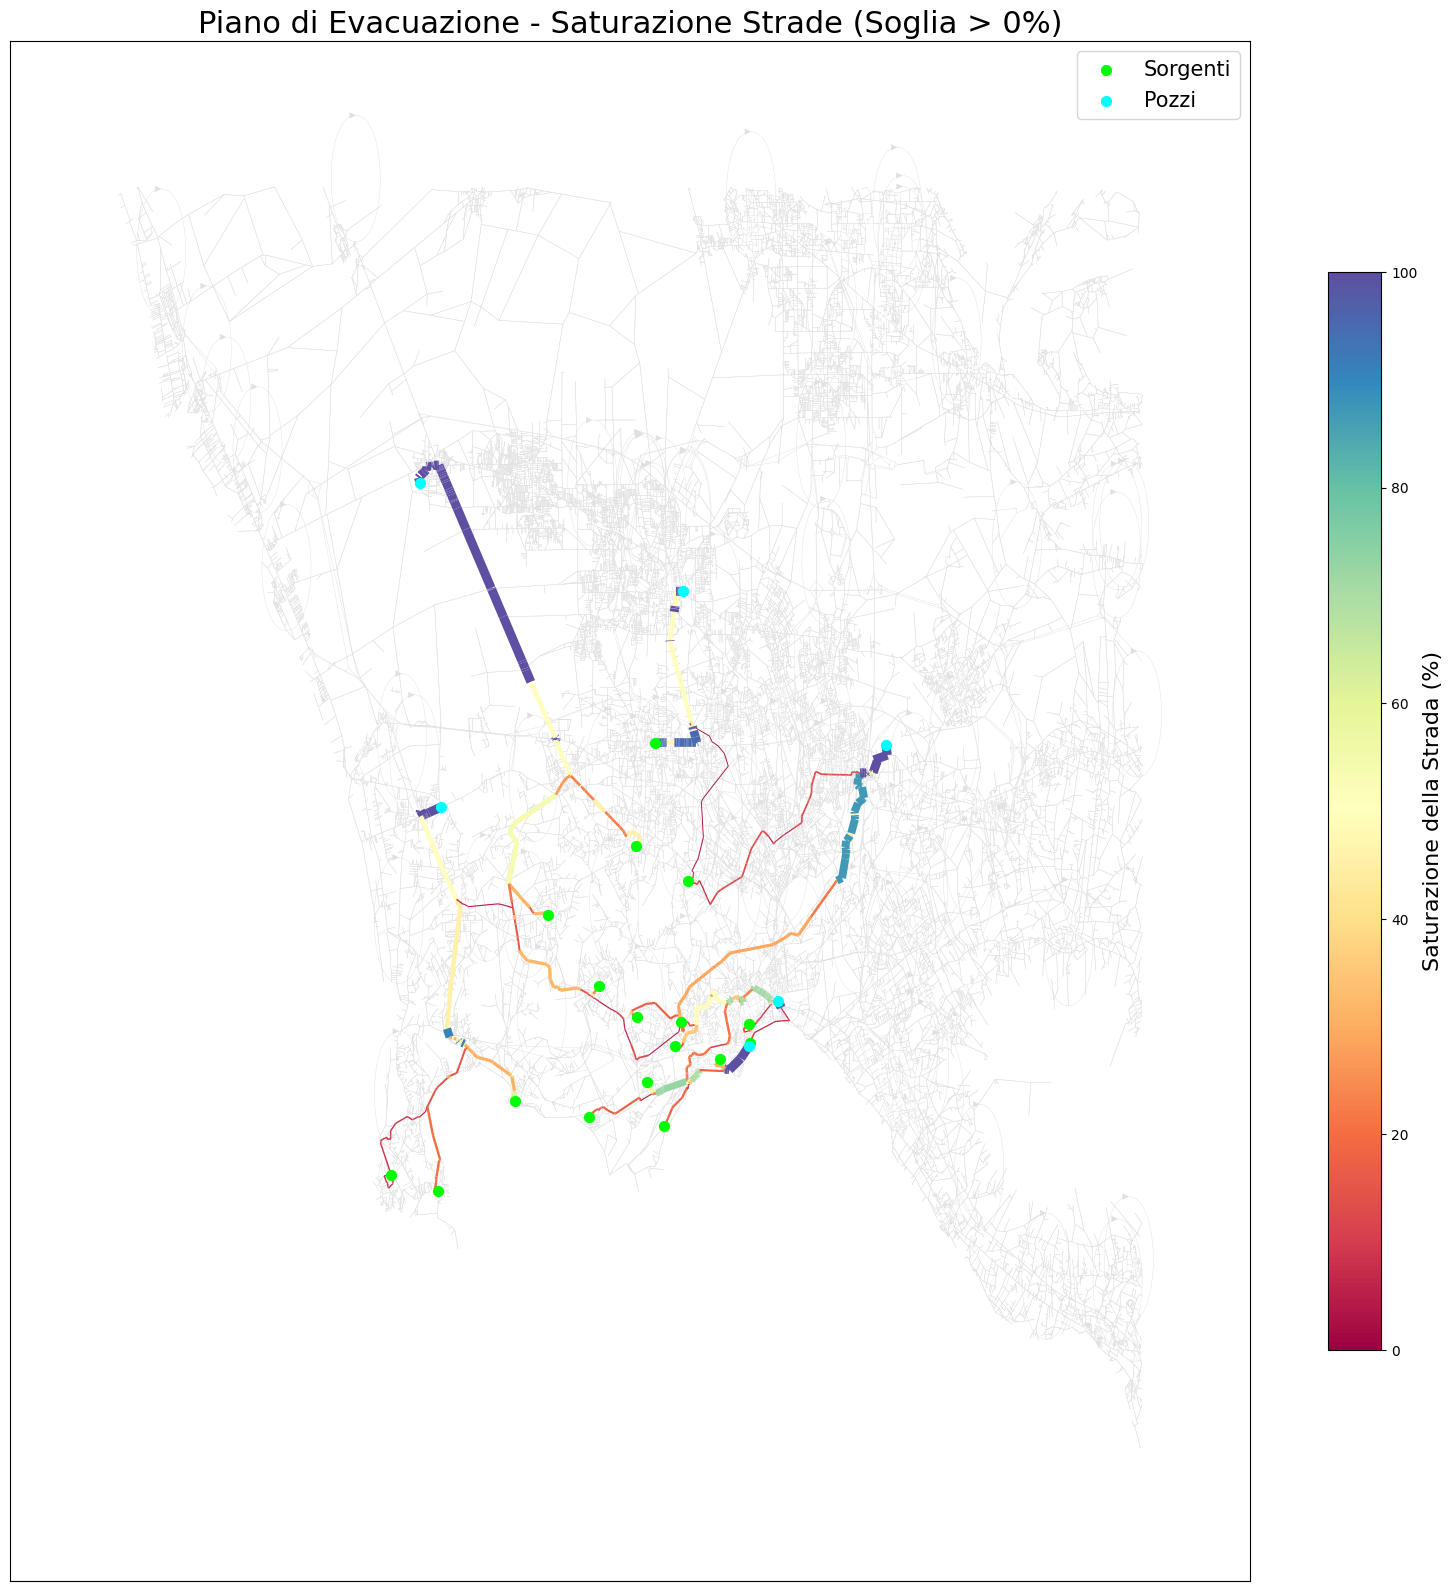

In [45]:
if best_time is not None and evacuation_plan is not None:
    # Mostra tutte le strade utilizzate (soglia = 0)
    visualizza_piano_statico_pulito(
        G,
        evacuation_plan,
        best_time,
        population_sources,
        sink_nodes,
        soglia_saturazione=0,
        soglia_pop_label=75000
    )
else:
    print("Nessun piano di evacuazione da visualizzare.")

#### Mappa interattiva

In [47]:
if best_time is not None and evacuation_plan is not None:
    # Mostra tutte le strade utilizzate (soglia = 0)
    visualizza_mappa_interattiva(
        G,
        evacuation_plan,
        best_time,
        population_sources,
        sink_nodes)
else:
    print("Nessun piano di evacuazione da visualizzare.")

Mappa salvata in 'mappa_evac.html'


## Fase 4: Scenari Avversi

Abbiamo provato ad immaginare situazioni sfavorevoli per il nostro piano, così da valutare la robustezza del nostro modello. Cosa succede se proviamo a chiudere alcune strade con una saturazione molto elevata? Cosa succede se riduciamo la capacità di alcune strade principali? Il nostro approccio continua a funzionare?

##### Helper functions

In [ ]:
import copy

def calculate_saturation(graph, flow_plan, best_time):
    """
    Calcola la saturazione degli archi del grafo in base al piano di flusso e al tempo ottimale ottenuti.
    """
    saturations = {}
    for u, v, data in graph.edges(data=True):
        flow_in_vehicles = flow_plan.get((u, v), 0) # Recupera il flusso in veicoli sull'arco (u, v) dal piano di flusso

        capacity_per_hour = data.get('capacity', 1) # Capacità dell'arco in veicoli per ora (default a 1 se non specificata)
        total_capacity_in_period = capacity_per_hour * best_time # Calcola la capacità totale dell'arco in base al tempo T*

        if total_capacity_in_period > 0 and flow_in_vehicles > 0: # Se l'arco ha capacità e flusso positivo
            saturations[(u, v)] = flow_in_vehicles / total_capacity_in_period # Calcola la saturazione in percentuale
        else:
            saturations[(u, v)] = 0.0

    return saturations

def create_scenario_remove_edge(graph, flow_plan, best_time, top_k=3):
    """
    SCENARIO AVVERSO 1: Guasto strutturale - Rimuove gli archi con maggiore saturazione
    Rimuove i primi 'top_k' archi più saturi dal grafo, in modo da simulare un guasto strutturale.
    """

    print(f"\n--- SCENARIO AVVERSO 1: Rimozione dei {top_k} archi più saturi ---")

    saturation = calculate_saturation(graph, flow_plan, best_time) # Calcola la saturazione di tutti gli archi
    sorted_edges = sorted(saturation.items(), key=lambda x: x[1], reverse=True) # Ordina gli archi per saturazione decrescente

    graph_scenario = graph.copy() # Per non sporcare il grafo originale

    edges_to_remove = [] # Lista degli archi da rimuovere
    selected_names = set()  # Per evitare duplicati nei nomi delle strade
    invalid_names = {'Sconosciuta', 'N/D', None}

    for edge_tuple, saturation in sorted_edges:
        if len(edges_to_remove) >= top_k: #Se abbiamo già rimosso 'top_k' archi, interrompiamo
            break

        (u, v) = edge_tuple
        if graph_scenario.has_edge(u, v):
            edge_data = graph_scenario.edges[u, v]
            nome_via = edge_data.get('name', 'Sconosciuta') # Se non c'è nome, usiamo 'Sconosciuta'

            # Controlla se il nome è valido e non è già stato selezionato
            if nome_via not in invalid_names and nome_via not in selected_names:
                edges_to_remove.append((edge_tuple, saturation))
                selected_names.add(nome_via)

    if not edges_to_remove:
        print("Nessun arco da rimuovere. Nessuno scenario avverso creato.")
        return graph_scenario

    # Rimuovi gli archi selezionati
    for (u, v), saturation in edges_to_remove:
        if graph_scenario.has_edge(u, v):
            nome_via = graph_scenario.edges[u, v].get('name', 'Sconosciuta')
            print(f"  - Rimuovo: '{nome_via}' (Arco {u}-{v}) [Saturazione (stimata): {saturation:.1%}]")
            graph_scenario.remove_edge(u, v)

    return graph_scenario

def create_scenario_capacity_reduction(graph, flow_plan, best_time,saturation_threshold=0.8, reduction_factor=0.5):
    """
    SCENARIO AVVERSO 2: Riduzione della capacità degli archi saturi
    Riduce la capacità degli archi che superano una certa soglia di saturazione.
    """
    print(f"\n--- SCENARIO AVVERSO 2: Riduzione della capacità degli archi saturi (soglia {saturation_threshold*100}%) ---")

    saturations = calculate_saturation(graph, flow_plan, best_time)
    graph_scenario = graph.copy()

    changed_edges = 0

    for (u, v), saturation in saturations.items():
        if saturation >= saturation_threshold: # Se la saturazione supera la soglia
            if graph_scenario.has_edge(u, v):
                edge_data = graph_scenario.edges[u, v]
                nome_via = edge_data.get('name', 'Sconosciuta')
                original_capacity = edge_data['capacity']
                new_capacity = original_capacity * reduction_factor  # Riduci la capacità del reduzion_factor
                edge_data['capacity'] = new_capacity
                print(f"  - '{nome_via}': Capacità ridotta a {new_capacity:.0f} [Saturazione (stimata): {saturation:.1%}]")
                changed_edges += 1

    if changed_edges == 0:
        print("Nessun arco ha superato la soglia. Nessuno scenario creato.")

    return graph_scenario

def create_scenario_remove_edge_flex(graph, flow_plan, best_time, k=1, rank_start=6):
    """
    SCENARIO AVVERSO 1 Flessibile: rimuove 'k' strade con nomi unici,
    partendo dalla posizione 'rank_start' nella classifica di saturazione
    """

    print(f"\n--- SCENARIO: Rimozione di {k} strade a partire dalla posizione {rank_start+1} ---")

    saturation = calculate_saturation(graph, flow_plan, best_time)
    sorted_edges = sorted(saturation.items(), key=lambda x: x[1], reverse=True)

    graph_scenario = graph.copy()

    edges_to_remove = []
    selected_names = set()  # Per evitare duplicati nei nomi delle strade
    invalid_names = {'Sconosciuta', 'N/D', None}

    for edge_tuple, saturation in sorted_edges[rank_start:]: # Inizia dalla posizione 'rank_start'
        if len(edges_to_remove) >= k:
            break

        (u, v) = edge_tuple
        if graph_scenario.has_edge(u, v):
            edge_data = graph_scenario.edges[u, v]
            nome_via = edge_data.get('name', 'Sconosciuta')

            # Controlla se il nome è valido e non è già stato selezionato
            if nome_via not in invalid_names and nome_via not in selected_names:
                edges_to_remove.append((edge_tuple, saturation))
                selected_names.add(nome_via)

    if not edges_to_remove:
        print("Nessun arco da rimuovere. Nessuno scenario avverso creato.")
        return graph_scenario

    for (u, v), saturation in edges_to_remove:
        if graph_scenario.has_edge(u, v):
            nome_via = graph_scenario.edges[u, v].get('name', 'Sconosciuta')
            print(f"  - Rimuovo: '{nome_via}' (Arco {u}-{v}) [Saturazione (stimata): {saturation:.1%}]")
            graph_scenario.remove_edge(u, v)

    return graph_scenario

# Funzione per stampare il report dello scenario
def print_report_scenario(scenario_name, time_base, G_scenario, time_scenario, flow_plan_scenario, sources):
    print(f"\n--- REPORT PER: '{scenario_name.upper()}' ---")

    if time_scenario is None:
        print("Problema inammissibile!. Impossibile trovare un piano di evacuazione.")
    else:
        print(f"Tempo di evacuazione stimato: {time_scenario:.2f} ore")
        print("Flusso sulle strade (persone/veicoli sull'intero periodo):")
        total_flow_out = 0
        for(u, v), flow_val in flow_plan_scenario.items():
            if flow_val > 1e-6:
                capacity_total = G_scenario.edges[u, v]['capacity'] * time_scenario #
                if capacity_total > 0:
                    saturation = (flow_val / capacity_total) * 100
                    nome_via = G_scenario.edges[u, v].get('name', 'Sconosciuta')
                    if isinstance(nome_via, list):
                        nome_via = nome_via[0]
                    print(f"  - Arco '({nome_via})' da {u} a {v}: {flow_val:.0f} persone [Saturazione: {saturation:.1f}%]")
                if u in sources:
                    total_flow_out += flow_val
        print(f"\nFlusso totale in uscita dalle sorgenti: {total_flow_out:.0f}")
        print(f"Popolazione totale da evacuare: {sum(sources.values()):.0f}")
        print(f"\nConfronto con lo scenario base:")
        print(f"Tempo originale: {time_base:.2f} ore, Tempo scenario: {time_scenario:.2f} ore")
    if time_scenario is not None:
        print(f"Aumento del tempo: {((time_scenario - time_base) / time_base) * 100:.2f}%")
    else:
        print("Nessun aumento del tempo calcolabile (scenario inammissibile).")

In [13]:
saturation = calculate_saturation(G, evacuation_plan, best_time)
sorted_edges = sorted(saturation.items(), key=lambda x: x[1], reverse=True)

print("\n--- Archi Ordinati per Saturazione (Top 10) ---")
for (u, v), saturazione in sorted_edges[:10]:
    nome_via = G.edges[u, v].get('name', 'Sconosciuta')
    if isinstance(nome_via, list):
        nome_via = nome_via[0]
    print(f"  - Da {u} a {v} ({nome_via}): Saturazione {saturazione:.2f}%")



--- Archi Ordinati per Saturazione (Top 10) ---
  - Da 1242005455 a 3420057515 (Via Giorgio Arcoleo): Saturazione 1.00%
  - Da 1242030803 a 3455594756 (Sconosciuta): Saturazione 1.00%
  - Da 1242030813 a 1242030803 (Sconosciuta): Saturazione 1.00%
  - Da 3420057514 a 1242030813 (Via Giorgio Arcoleo): Saturazione 1.00%
  - Da 3420057515 a 3420057514 (Via Giorgio Arcoleo): Saturazione 1.00%
  - Da 3455594756 a 9055605241 (Via Ferdinando Acton): Saturazione 1.00%
  - Da 15413732 a 1125010646 (Ramo H39): Saturazione 1.00%
  - Da 19059466 a 1223309676 (Sconosciuta): Saturazione 1.00%
  - Da 300149800 a 300149778 (Sconosciuta): Saturazione 1.00%
  - Da 596529100 a 620637294 (Strada Provinciale 527 Variante San Salvatore): Saturazione 1.00%


#### **Scenario 1 (Rimozione archi)**
Se eliminiamo l'unica strada possibile per arrivare ad una destinazione, non è possibile trovare una soluzione.

In [49]:
scenario_name = "Scenario Avverso 1: Rimozione Archi Saturi"

graph_scenario_1 = create_scenario_remove_edge(G, evacuation_plan, best_time, top_k=2)

# Risolvi il flusso per lo scenario avverso 1
time_scenario_1, flow_plan_scenario_1 = find_quickest_evacuation_time(graph_scenario_1, population_sources, sink_nodes)

print_report_scenario(
    scenario_name,
    best_time,
    graph_scenario_1,
    time_scenario_1,
    flow_plan_scenario_1,
    population_sources
)


--- SCENARIO AVVERSO 1: Rimozione dei 2 archi più saturi ---
  - Rimuovo: 'Via Giorgio Arcoleo' (Arco 1242005455-3420057515) [Saturazione (stimata): 100.0%]
  - Rimuovo: 'Via Ferdinando Acton' (Arco 3455594756-9055605241) [Saturazione (stimata): 100.0%]
Inizio ricerca del tempo di evacuazione per 312400.0 persone.
Il limite superiore T_max=24 ore non è sufficiente. Raddoppio.
Il limite superiore T_max=48 ore non è sufficiente. Raddoppio.
Il limite superiore T_max=96 ore non è sufficiente. Raddoppio.
Il limite superiore T_max=192 ore non è sufficiente. Raddoppio.
Limite superiore T_max troppo alto, impossibile trovare una soluzione.
Impossibile trovare un limite superiore feasible per il tempo di evacuazione.

--- REPORT PER: 'SCENARIO AVVERSO 1: RIMOZIONE ARCHI SATURI' ---
Problema inammissibile!. Impossibile trovare un piano di evacuazione.
Nessun aumento del tempo calcolabile (scenario inammissibile).


#### **Scenario 2: Riduzione capacità**

In [50]:
scenario_name = "Scenario Avverso 2: Riduzione Capacità Archi Saturi"

graph_scenario_2 = create_scenario_capacity_reduction(G, evacuation_plan, best_time,saturation_threshold=0.8, reduction_factor=0.5)

# Risolvi il flusso per lo scenario avverso 2
time_scenario_2, flow_plan_scenario_2 = find_quickest_evacuation_time(graph_scenario_2, population_sources, sink_nodes)

print_report_scenario(
    scenario_name,
    best_time,
    graph_scenario_2,
    time_scenario_2,
    flow_plan_scenario_2,
    population_sources
)


--- SCENARIO AVVERSO 2: Riduzione della capacità degli archi saturi (soglia 80.0%) ---
  - 'Ramo H39': Capacità ridotta a 900 [Saturazione (stimata): 87.1%]
  - 'Sconosciuta': Capacità ridotta a 900 [Saturazione (stimata): 100.0%]
  - 'Via Santa Maria a Cubito': Capacità ridotta a 900 [Saturazione (stimata): 100.0%]
  - 'Sconosciuta': Capacità ridotta a 900 [Saturazione (stimata): 100.0%]
  - 'Sconosciuta': Capacità ridotta a 900 [Saturazione (stimata): 100.0%]
  - 'Strada Provinciale 527 Variante San Salvatore': Capacità ridotta a 900 [Saturazione (stimata): 87.1%]
  - 'Strada Provinciale 527 Variante San Salvatore': Capacità ridotta a 900 [Saturazione (stimata): 87.1%]
  - 'Via Colonne': Capacità ridotta a 900 [Saturazione (stimata): 95.3%]
  - 'Corso Campano': Capacità ridotta a 900 [Saturazione (stimata): 95.3%]
  - 'Corso Campano': Capacità ridotta a 900 [Saturazione (stimata): 95.3%]
  - 'Ramo H39': Capacità ridotta a 900 [Saturazione (stimata): 87.1%]
  - 'Ramo H39': Capacità r

#### **Scenario 3: Rimozione archi flessibile**

In [56]:
scenario_name = "Scenario Avverso 3: Rimozione Archi Flessibile"

graph_scenario_3 = create_scenario_remove_edge_flex(G, evacuation_plan, best_time, k=5, rank_start=10)

# Risolvi il flusso per lo scenario avverso flex
time_scenario_3, flow_plan_scenario_3 = find_quickest_evacuation_time(graph_scenario_3, population_sources, sink_nodes)

print_report_scenario(
    scenario_name,
    best_time,
    graph_scenario_3,
    time_scenario_3,
    flow_plan_scenario_3,
    population_sources
)


--- SCENARIO: Rimozione di 5 strade a partire dalla posizione 11 ---
  - Rimuovo: 'Piazza Giuseppe Mazzini' (Arco 1151998085-1151998106) [Saturazione (stimata): 100.0%]
  - Rimuovo: 'Strada Provinciale Santa Maria a Cubito - Giugliano' (Arco 1224125843-8671976892) [Saturazione (stimata): 100.0%]
  - Rimuovo: 'Via Pietro Nenni' (Arco 1234828159-1505635653) [Saturazione (stimata): 100.0%]
  - Rimuovo: 'Strada Provinciale 18 Villa Literno' (Arco 1276155193-1276155123) [Saturazione (stimata): 100.0%]
  - Rimuovo: 'Via Armando Diaz' (Arco 1438271244-4415690233) [Saturazione (stimata): 100.0%]
Inizio ricerca del tempo di evacuazione per 312400.0 persone.
Il limite superiore T_max=24 ore non è sufficiente. Raddoppio.
Trovato un limite superiore feasible: 48 ore. Inizio ricerca binaria.
Iterazione 1: Intervallo [0.00, 48.00], Tento T = 24.00
Iterazione 2: Intervallo [24.00, 48.00], Tento T = 36.00
Iterazione 3: Intervallo [24.00, 36.00], Tento T = 30.00
Iterazione 4: Intervallo [24.00, 30.00]

##### Visualizzazione Scenario 3

In [57]:
if time_scenario_3 is not None and flow_plan_scenario_3 is not None:
    # Mostra tutte le strade utilizzate (soglia = 0)
    visualizza_mappa_interattiva(
        G,
        flow_plan_scenario_3,
        time_scenario_3,
        population_sources,
        sink_nodes)
else:
    print("Nessun piano di evacuazione da visualizzare per lo scenario avverso 3.")

Mappa salvata in 'mappa_evac.html'


## Conclusioni e Sviluppi Futuri

Questo notebook ha implementato un algoritmo di 2-approssimazione per il problema del flusso più rapido, fornendo un piano di evacuazione e una stima del tempo necessario.

**Come interpretare i risultati:**
- Il **tempo di evacuazione** è la stima del tempo minimo necessario per completare l'operazione.
- Il **piano di flusso** indica quante persone/veicoli dovrebbero percorrere ogni strada durante l'intera evacuazione.
- La **saturazione** è l'indicatore più importante: strade con saturazione vicina al 100% sono i **colli di bottiglia** del sistema. Qualsiasi intervento per migliorare i tempi di evacuazione dovrebbe concentrarsi su queste strade.